In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spacy
import textacy
from glob import glob
import ete3
from ete3 import Tree, TreeStyle, TextFace, add_face_to_node
from sklearn.decomposition import PCA
%matplotlib inline
plt.rcParams['figure.figsize'] = (24,12)
plt.style.use('ggplot')

In [2]:
james = textacy.Corpus.load('.', 'james', compression='gzip')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 25: invalid start byte

In [3]:
filenames = glob('text/*')
texts = [open(text).read() for text in filenames]
metadata = [{'filename': fn} for fn in filenames]
james = textacy.Corpus('en', texts, metadatas=metadata)

In [10]:
class SentenceTree(): 
    def __init__(self, sent): 
        """ Takes a SpaCy sentence as input. """ 
        self.sent = sent
        self.root = sent.root
        self.vector = self.countLevels(self.sent)
        self.max = max(self.vector)
        self.sentDict = self.sentToDict(self.root)
        self.newick = self.newickify(self.sentDict) + ';'
        try: 
            self.tree = Tree(self.newick, format=1)
            self.maxDist = self.tree.get_farthest_leaf()[1]
            self.branchDepth = [len(branch.get_descendants()) for branch in self.tree.children]
            self.branchDepthSTD = pd.Series(self.branchDepth).std()
        except: 
            return None
        
    def countLevels(self, sent):
        """ Create a numeric representation vector of a syntactic tree by counting the numbers
        of child nodes at each level of the tree. """
#         print('Counting levels for sentence: ', sent)
        sentRoot = sent.root
        counts = [1, len(list(sentRoot.children))]
        branches = list(sentRoot.children)
        children = []
        while branches != []: 
    #         print('---Branches: ', branches)
            for branch in branches: 
    #             print('Branch: ', branch)
    #             print('Children: ', list(branch.children))
                for child in list(branch.children): 
                    children.append(child)
    #             print('Children list: ', children)
            counts.append(len(children))
            branches = children.copy()
            children = []
        return counts
    
    def isPunct(self, thing): 
        if type(thing) == str: 
            if thing.strip() in "!@#$%^&*()_+-=,./<>?;'\":[]\{}|`~": 
                return True
        return False

    def sentToDict(self, node): 
        children = [child for child in node.children 
                   if self.isPunct(child.string.strip()) == False # ignore punctuation
                   and child.tag_ != 'SP'] #ignore spaces and newlines
        root = node.string.strip()
        if len(children) == 0: 
            return node.string.strip()
        return {node.string.strip(): [self.sentToDict(child) 
                                      for child in children]}

    def newickify(self, node): 
        if type(node) == str:
            return node.strip()
        root = list(node)[0]
        return '(' + ','.join([self.newickify(child) 
            for child in node[root] ]) + ')' + root
    
    def render(self, textMode=False, radial=True): 
        """ 
        textMode=False will show a graphical tree. 
        textmode=True will show an ASCII tree. 
        """
        t = self.tree
        if textMode: 
            print(t.get_ascii(show_internal=True))
        else: 
            ts = TreeStyle()
            ts.show_leaf_name = False
            #TODO: make this not be a function
            def my_layout(node):
                F = TextFace(node.name, tight_text=False)
                add_face_to_node(F, node, column=0, position="branch-right")
            ts.layout_fn = my_layout
            if radial: 
                   ts.mode='c'
            return t.render('%%inline', tree_style=ts)

In [11]:
class SentenceStats(): 
    def __init__(self, doc): 
        """ Takes a SpaCy document as input. """
        self.doc = doc
        self.sents = list(doc.sents) 
        self.sentObjs = [SentenceTree(sent) for sent in self.sents if SentenceTree(sent) is not None]
        self.vectors = [sent.vector for sent in self.sentObjs]
        self.maxes = [sent.max for sent in self.sentObjs]
        self.averageSent = self.averageVectors(self.vectors)

    def averageVectors(self, vectorList): 
        """ Does an element-wise average for all the vectors in a list. """
        lengths = [len(vector) for vector in vectorList]
        maxLength = max(lengths)
        for vector in vectorList: 
            while len(vector) < maxLength: 
                vector.append(0) # Zero-pad
        vectorList = np.array(vectorList)
        return vectorList.mean(axis=0) # average each column
    
    def plotAverageSent(self): 
        pd.Series(self.averageSent).plot(kind="bar")

In [14]:
averageSents = {t.metadata['filename']: SentenceStats(t).averageSent for t in james}

In [26]:
df = pd.DataFrame.from_dict(averageSents, orient='index') # Hack to make arrays the same length 
df = df.sort_index()

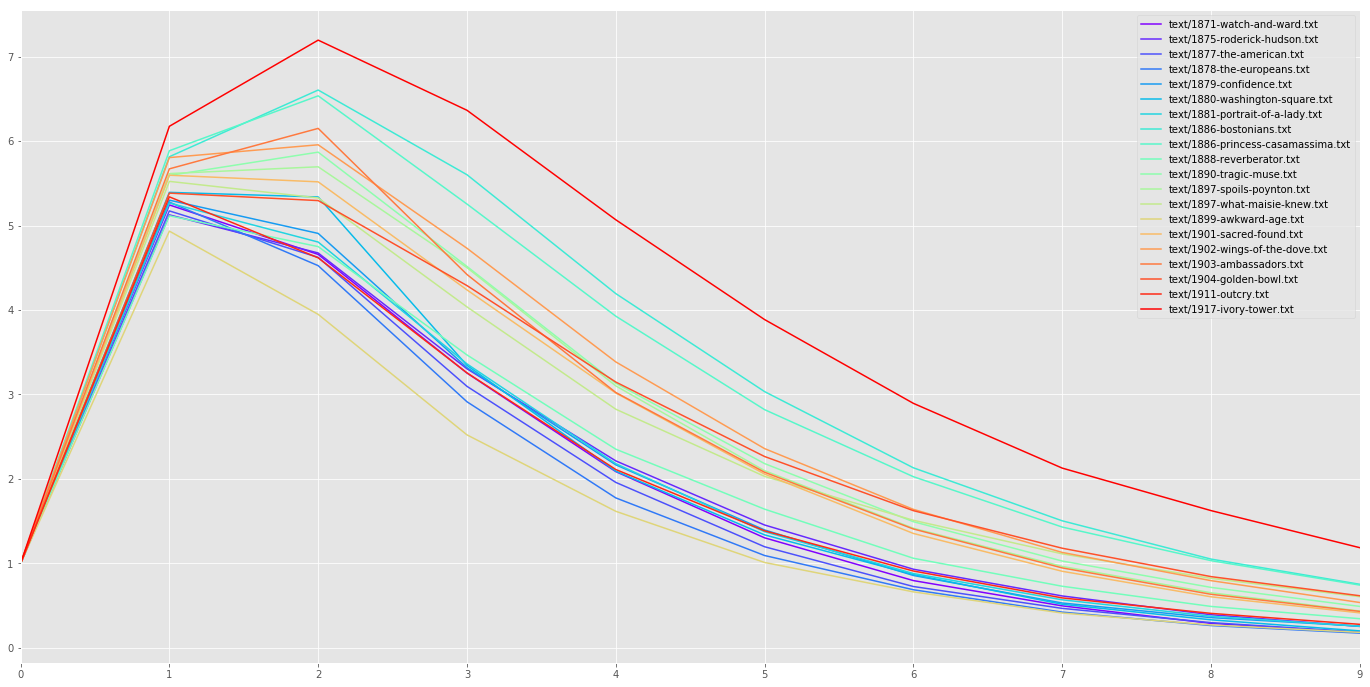

In [36]:
df.T[:10].plot(cmap='rainbow')

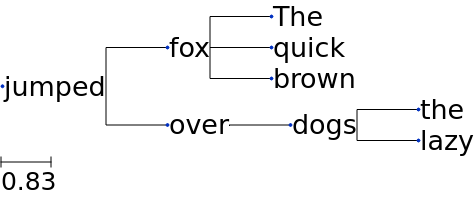

In [45]:
doc = textacy.Doc('The quick brown fox jumped over the lazy dogs.')
sdoc = next(doc.spacy_doc.sents)
tree = SentenceTree(sdoc)
tree.render(radial=False)

# Other Things

In [ ]:
longSents = []
for doc in james: 
    for sent in doc.sents: 
        if len(sent) > 200: 
            longSents.append((sent, doc.metadata['filename'], len(sent)))

In [ ]:
pd.Data

In [ ]:
[sent[1] for sent in longSents]

In [ ]:
[sent[2] for sent in longSents]

In [ ]:
t = SentenceTree(longSents[2][0])

In [ ]:
for sent in longSents: 
    print(SentenceTree(sent[0]).branchDepthSTD)

In [ ]:
ls3 = SentenceTree(longSents[3][0])

In [ ]:
ls3.branchDepthSTD

In [ ]:
ls3.render()

In [ ]:
SentenceTree(longSents[2][0]).render(radial=False)

In [ ]:
SentenceTree(longSents[1][0]).render(radial=False)

In [ ]:
SentenceTree(longSents[1][0]).vector

In [ ]:
sentenceStats.countLevels(None, longSents[-2][0]

# Cluster by vectors

In [ ]:
averages = [sentenceStats(doc).averageSent for doc in james]

In [ ]:
labels = [doc.metadata['filename'] for doc in james]

In [ ]:
df = pd.DataFrame(averages, index=labels)
df = df.fillna(0)

In [ ]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(df)

In [ ]:
plt.scatter(reduced[:,0], reduced[:,1])
for line, label in zip(reduced, labels): 
    plt.annotate(label, line)

# Find the highest branch depth standard deviation ("digressiveness?")

In [ ]:
branchSTDs = []
for doc in james: 
    for sent in doc.sents: 
        try: 
            st = SentenceTree(sent)
        except: 
            continue
        if st.branchDepthSTD > 50: 
            branchSTDs.append(st)

In [ ]:
len(branchSTDs)

In [ ]:
sortedBranchSTDs = sorted(branchSTDs, key=lambda x: x.branchDepthSTD)


In [ ]:
sortedBranchSTDs[-1].branchDepthSTD

In [ ]:
high = sortedBranchSTDs[-1]

In [ ]:
high.render(radial=False)

In [ ]:
high.sent.doc